In [1]:
# pytorch model 구현

# IMDB데이터 준비
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100) # 샘플 길이 100
val_seq = pad_sequences(val_input, maxlen=100)

2025-09-01 13:54:23.349866: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-01 13:54:23.376367: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-01 13:54:23.376394: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-01 13:54:23.376415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-01 13:54:23.381093: I tensorflow/core/platform/cpu_feature_g

In [2]:
# train data 크기 확인
print(train_seq.shape, train_target.shape)

(20000, 100) (20000,)


In [3]:
# pytorch 데이터 로더에 사용하려면 pytorch tensor로 변환 해야 함
import torch

train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)

In [4]:
# target data type 확인
print(train_target.dtype)

int64


In [5]:
# pytorch 손실 함수는 입력으로 실수 값을 기대
# 각 target 값을 실수형 텐서로 변환
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [6]:
# data type 확인
print(train_target.dtype)

torch.float32


In [7]:
# 데이터 로더로 훈련세트 검증세트 준비
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=64, shuffle=False)

In [8]:
# 모델 구현
import torch.nn as nn

class IMDBRnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(500,16) # 임베딩 층 (어휘사전크기,임베딩벡터크기), 입력(배치크기,시퀀스길이) -> 출력(배치크기,시퀀스길이,임베딩크기)
        self.rnn = nn.RNN(16,8,batch_first=True) # 기본 순환층 (임베딩벡터크기,뉴런개수), 입력(시퀀스길이,배치크기,임베딩크기) -> batch_first가 True이므로 출력(배치크기,시퀀스길이,임베딩크기)
        self.dense = nn.Linear(8,1)
        self.sigmoid = nn.Sigmoid() # 이진분류이므로 활성화함수 sigmoid
    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x) # 여러개의 순환층을 쌓으려면 num_layers 매개변수에서 층개수 지정, 마지막 층에서 나온 각 타임스텝의 hidden state와 최종 hidden state 두 개를 반환
        outputs = self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [9]:
# 각 타임스텝의 hidden state는 batch_first가 True면 (배치크기,시퀀스길이,뉴련개수), False면 (시퀀스길이,배치크기,뉴런개수)
# 최종 hidden state의 크기는 (층 개수,배치크기,뉴런개수)
# 이 예제는 각 샘플의 길이 100, 1개 순환층, 64개 배치를 사용 -> 첫 번째 출력의 크기 (64,100,8), 두 번째 출력의 크기 (64,100,8)
# 이 예제에서 각 타임스텝의 hidden state는 불필요하므로 각 객체가 반환하는 두 번째 값만 hidden변수에 저장해서 사용

In [10]:
# 모델 객체 생성 및 GPU로 전달
model = IMDBRnn()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수와 옵티마이저 정의
import torch.optim as optim

criterion = nn.BCELoss() # 이진분류 -> 시그모이드 함수 -> nn.BCELoss() 사용
optimizer = optim.Adam(model.parameters(), lr=2e-4) # 학습률을 기본값보다 낮춤

In [11]:
# (64,100) 크기의 배치입력을 받아 마지막 시그모이드 함수를 통과한(64,1)  크기 값을 출력
# but 타깃 값은 1차원 배열, 데이터로더가 반환한 크기 -> (64,)
# 손실 함수에서 두 값을 사용하기위해 squeeze() 메서드로 크기가 1인 차원삭제 필요

In [12]:
# 모델 훈련 코드
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets) # squeeze()로 크기가 1인 차원 삭제
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 검증 손실 계산
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets) # squeeze()로 크기가 1인 차원 삭제
            val_loss += loss.item()

    # 평균 훈련손실과 평균 검증 손실 계산 (데이터로더에 len()함수를 적용하면 배치 반복 횟수 반환)
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1},",f"훈련 손실:{train_loss:.4f}, 검증 손실:{val_loss:.4f}") # 에포크 손실 출력

    # 조기 종료
    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1
    if early_stopping_counter >= patience:
        print(f"{epoch+1}번쨰 에포크에서 조기 종료되었습니다.")
        break

에포크:1, 훈련 손실:0.6972, 검증 손실:0.6953
에포크:2, 훈련 손실:0.6932, 검증 손실:0.6929
에포크:3, 훈련 손실:0.6911, 검증 손실:0.6906
에포크:4, 훈련 손실:0.6893, 검증 손실:0.6888
에포크:5, 훈련 손실:0.6874, 검증 손실:0.6869
에포크:6, 훈련 손실:0.6856, 검증 손실:0.6847
에포크:7, 훈련 손실:0.6837, 검증 손실:0.6829
에포크:8, 훈련 손실:0.6816, 검증 손실:0.6809
에포크:9, 훈련 손실:0.6794, 검증 손실:0.6787
에포크:10, 훈련 손실:0.6768, 검증 손실:0.6760
에포크:11, 훈련 손실:0.6742, 검증 손실:0.6736
에포크:12, 훈련 손실:0.6712, 검증 손실:0.6719
에포크:13, 훈련 손실:0.6679, 검증 손실:0.6678
에포크:14, 훈련 손실:0.6639, 검증 손실:0.6644
에포크:15, 훈련 손실:0.6596, 검증 손실:0.6603
에포크:16, 훈련 손실:0.6546, 검증 손실:0.6559
에포크:17, 훈련 손실:0.6490, 검증 손실:0.6501
에포크:18, 훈련 손실:0.6429, 검증 손실:0.6447
에포크:19, 훈련 손실:0.6369, 검증 손실:0.6389
에포크:20, 훈련 손실:0.6309, 검증 손실:0.6344
에포크:21, 훈련 손실:0.6248, 검증 손실:0.6285
에포크:22, 훈련 손실:0.6188, 검증 손실:0.6225
에포크:23, 훈련 손실:0.6127, 검증 손실:0.6173
에포크:24, 훈련 손실:0.6074, 검증 손실:0.6120
에포크:25, 훈련 손실:0.6022, 검증 손실:0.6086
에포크:26, 훈련 손실:0.5967, 검증 손실:0.6040
에포크:27, 훈련 손실:0.5927, 검증 손실:0.6001
에포크:28, 훈련 손실:0.5888, 검증 손실:0.5972
에포크:29, 훈련 손실:0.5846, 검증 손실:0

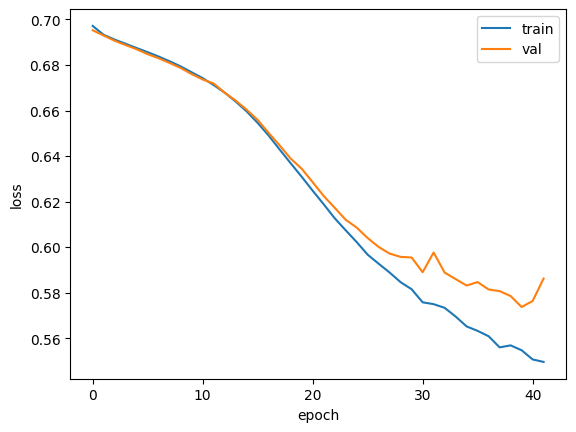

In [13]:
# 훈련손실 검증손실 그래프
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 최종적으로 테스트 세트에 대한 모델 정확도 확인  
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs > 0.5
        corrects += (predicts.squeeze() == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.7086
